In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

/reg/g/psdm/sw/conda/inst/miniconda2-dev-rhel7/envs/ana-1.2.12-gpu/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


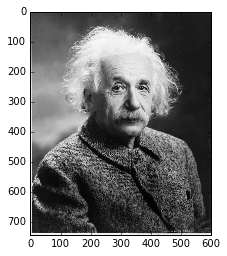

In [2]:
# Read in the image as greyscale
# Notice that in greyscale, black is 1 while while white is zero.
# So we need to do the transformation.
jpgfile = 1 - io.imread('./ALbertEinstein.jpg',as_grey=True)

# Show the image 
plt.imshow(jpgfile, cmap='Greys')
plt.show()

In [3]:
# Calculate the statistical properties of the image so that we can add proper noise
mean = np.mean(jpgfile)
std = np.std(jpgfile)
print("The mean value of the image is %f." %mean)
print("The standard deviation of the image is %f"%std)

The mean value of the image is 0.679365.
The standard deviation of the image is 0.251082


In [4]:
# Construct noisy images
noisy_data = np.zeros((50, jpgfile.shape[0], jpgfile.shape[1]))
for l in range(10):
    for m in range(5):
        noisy_data[l*5+m,:,:] = jpgfile[:,:] + np.random.normal(loc=0,scale=std*(l+4),
                                                                 size=jpgfile.shape)

In [5]:
# Construct the mirror image
mirror = np.fliplr(jpgfile)
# Construct the noise mirror images
noisy_data_mirror = np.zeros((50, jpgfile.shape[0], jpgfile.shape[1]))
for l in range(10):
    for m in range(5):
        noisy_data_mirror[l*5+m,:,:] = mirror[:,:] + np.random.normal(loc=0,scale=std*(l+4),
                                                                 size=jpgfile.shape)

In [26]:
noisy_data[0,:,:] = jpgfile
noisy_data_mirror[0,:,:] = mirror

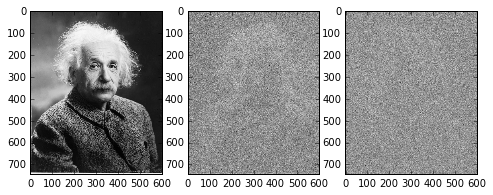

In [39]:
# Show noisy image
fig = plt.figure(figsize=(8,4))
fig.add_subplot('131')
plt.imshow(noisy_data[0,:,:], cmap="Greys")
fig.add_subplot('132')
plt.imshow(noisy_data_mirror[1,:,:], cmap="Greys")
fig.add_subplot('133')
plt.imshow(noisy_data[-1,:,:], cmap="Greys")
plt.show()


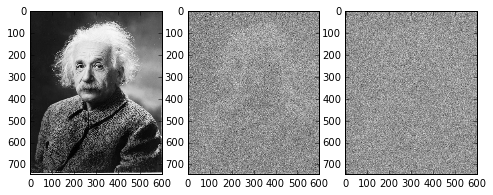

In [38]:
# Show noisy flipped image
fig = plt.figure(figsize=(8,4))
fig.add_subplot('131')
plt.imshow(noisy_data_mirror[0,:,:], cmap="Greys")
fig.add_subplot('132')
plt.imshow(noisy_data_mirror[1,:,:], cmap="Greys")
fig.add_subplot('133')
plt.imshow(noisy_data_mirror[-1,:,:], cmap="Greys")
plt.show()

In [30]:
# Calculate correlation matrix R
R = np.zeros((100,100))
# First normalize the data
data = np.zeros((100,noisy_data.shape[-2],noisy_data.shape[-1]))
data[:50,:,:] = noisy_data
data[50:,:,:] = noisy_data_mirror
data_mean = np.mean(data,axis=(1,2))
#data_std  = np.std(data,axis=(1,2))
data = data - data_mean[:,np.newaxis,np.newaxis]
data_norm  = np.sqrt(np.sum(np.square(data),axis=(1,2)))
data = data / data_norm[:,np.newaxis,np.newaxis]

for l in range(99):
    for m in range(l+1,100):
        R[l, m] = np.sum(np.multiply(data[l,:,:], data[m,:,:]))

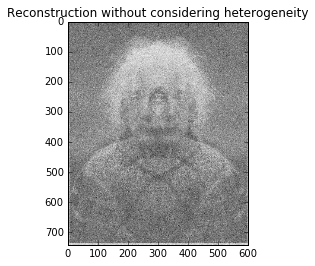

In [42]:
# Reconstruction without considering heterogeneity
meanImg = np.mean(data,axis=0)
plt.imshow(meanImg, cmap="Greys")
plt.title('Reconstruction without considering heterogeneity')
plt.show()

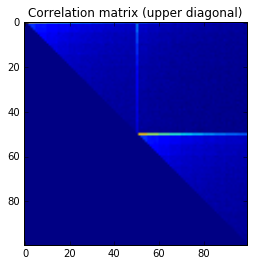

In [44]:
plt.imshow(R)
plt.title('Correlation matrix (upper diagonal)')
plt.show()

In [47]:
# Begin to calculate the embedding
try:
    import tensorflow as tf
except ImportError:
    R = np.load('./correlation.npy') # Load pre-calculated R matrix
import numpy as np

In [60]:
numData = np.shape(R)[0]
# Build the graph
initial_value = np.random.normal(scale=1,size=(numData,2))

X = tf.Variable(initial_value, trainable=True, dtype=tf.float64)
# Notice that I have only calculated the upper half correlation, so I have to symmetrize the 
# correlation before I apply it to the procedure.
Correlation = tf.constant(value= R + np.transpose(R),dtype=tf.float64)

# Notice that the diagonal part does not 
tmp1 = Correlation - tf.matmul(X,X,transpose_b=True)
tmp2 = tmp1 - tf.diag(tf.diag_part(tmp1))

loss = tf.reduce_sum(tf.square(tmp2))/np.float(numData**2 - numData)

iter 249: Loss 0.000002


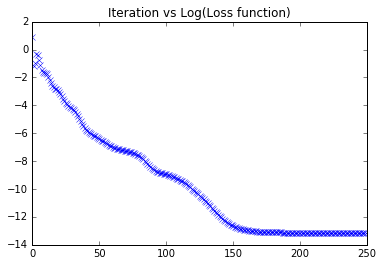

In [89]:
maxIter = 250
lossHistory = np.zeros((maxIter,))
opt = tf.train.AdamOptimizer(learning_rate=1).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(maxIter):
        lossHistory[i] = sess.run(loss)
        sess.run(opt)
    print('iter %d: Loss %f'%(i,sess.run(loss)))
    embedded = sess.run(X)

plt.plot(np.log(lossHistory),'x')
plt.title('Iteration vs Log(Loss function)')
plt.show()

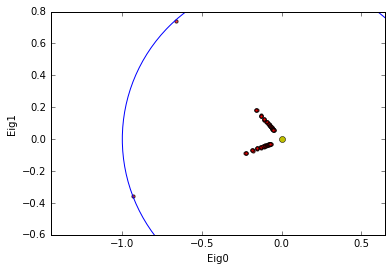

In [90]:
# Now Let's have a look at the result.
circle = plt.Circle((0, 0), 1, color='b', fill=False) # unit circle
ax = plt.gca()
ax.add_artist(circle)
ax.plot((0), (0), 'o', color='y') # origin
plt.scatter(x=embedded[:,0], y= embedded[:,1], s=10, c='r', alpha=0.75) # data
plt.axis('equal')
plt.xlabel('Eig0')
plt.ylabel('Eig1')
plt.show()

In [95]:
# Reconstruct by correcting heterogeneity
mirrorInd =  np.where(embedded[:,1] < 0)[0]
reconImg = np.zeros_like(jpgfile)
for i in range(numData):
    if i in mirrorInd:
        reconImg += np.fliplr(data[i,:,:])
    else:
        reconImg += data[i,:,:]
reconImg = reconImg/numData

plt.imshow(reconImg, cmap="Greys")
plt.title('Reconstruction considering heterogeneity')
plt.show()

(array([50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66,
       67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83,
       84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),)
